In [16]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import inspect, os
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
os.sys.path.insert(0,parentdir) 
from traces.trace_utils import *


from response_distributions_util import *
import pytz, datetime
import pandas as pd
import json

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Preparation

In [17]:
df = load_responses_with_traces()

In [18]:
df['click_dt_local'] = df.apply(lambda x: utc_to_local(x['click_dt_utc'], x['geo_data']['timezone']), axis = 1)

In [19]:
df = df[df['click_dt_local'].notnull()].copy()
print('Num Responses with a timezone', df.shape[0])

Num Responses with a timezone 29217


##### Set up  for hour of day plots

In [20]:
df['local_hour_of_day'] = df['click_dt_local'].apply(lambda x: x.hour)
df['local_hour_of_day_div2'] = df['click_dt_local'].apply(lambda x: 2 * int(x.hour / 2))
df['local_hour_of_day_div3'] = df['click_dt_local'].apply(lambda x: 3 * int(x.hour / 3))
df['local_hour_of_day_div4'] = df['click_dt_local'].apply(lambda x: 4 * int(x.hour / 4))

hour_of_day_div2_xticks = ['%d-%d' % e for e in zip(range(0, 24, 2), range(2, 25, 2))]
hour_of_day_div3_xticks = ['%d-%d' % e for e in zip(range(0, 24, 3), range(3, 25, 3))]
hour_of_day_div4_xticks = ['%d-%d' % e for e in zip(range(0, 24, 4), range(4, 25, 4))]

##### Set up for Day of Week and Weekend vs Weekday plots

In [21]:
def get_day_of_week(t): 
    
    return t.weekday()

def get_day_type(t): 
    if t.weekday() > 4:
        return 1
    else:
        return 0

df['local_day_of_week'] = df['click_dt_local'].apply(get_day_of_week)
df['local_day_type'] = df['click_dt_local'].apply(get_day_type)

day_of_week_xticks = [
            'Monday',
            'Tuesday',
            'Wednesday',
            'Thursday',
            'Friday',
            'Saturday',
            'Sunday'
    ]

day_type_xticks = ['weekday', 'weekend']


# Plots

### Motivation Weekday vs Weekend

In [22]:
d_single_motivation = df[df['motivation'].apply(lambda x: len(x.split('|')) == 1)]

In [23]:
print('Num Response Traces with a single motivation:', d_single_motivation.shape)

Num Response Traces with a single motivation: (20887, 24)


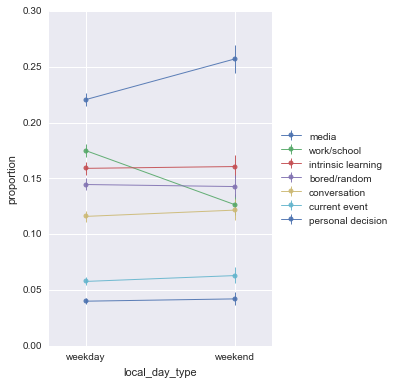

In [24]:
x = 'local_day_type'
hue = 'motivation'
d = d_single_motivation
xticks = day_type_xticks
figsize = (4, 6)
xlim = (-0.25, 1.25)
hue_order = ['media', 'work/school',  'intrinsic learning', 'bored/random', 'conversation', 'current event', 'personal decision']
title = 'Motivation by Weekday vs Weekend'
plot_over_time(d, x, xticks, hue, hue_order, figsize, xlim )

The proportion of respondents motivated by work/school drops significantly from weekday to weekend. The proportion of respondents motivated by media increase significantly from weekday to weekend. All other motivations see a very silgtht increase. 

### Motivation by Day of Week

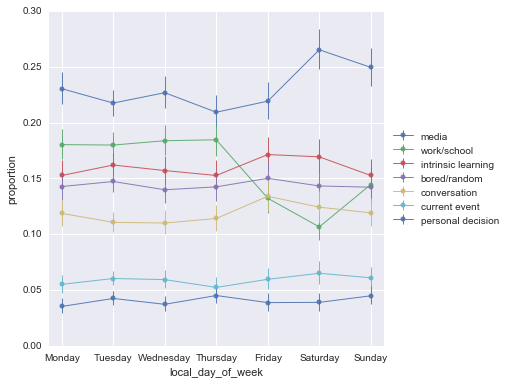

In [25]:
x = 'local_day_of_week'
hue = 'motivation'
d = d_single_motivation
xticks = day_of_week_xticks
figsize = (6, 6)
xlim = (-0.25, 6.25)
hue_order = ['media', 'work/school',  'intrinsic learning', 'bored/random', 'conversation', 'current event', 'personal decision']
plot_over_time(d, x, xticks, hue, hue_order, figsize, xlim )

Motivations besides media and work/school maintain a fairly constant proportion throughout the week. The work/school proportion stays at a high contant 20% M-Th, drops until Saturday to almost 10% and then rebounds on Sunday to 15%. Similarly, media stays at a high contant M-F, then Jumps up during the weekend. 

### Motivation: Hour of Day

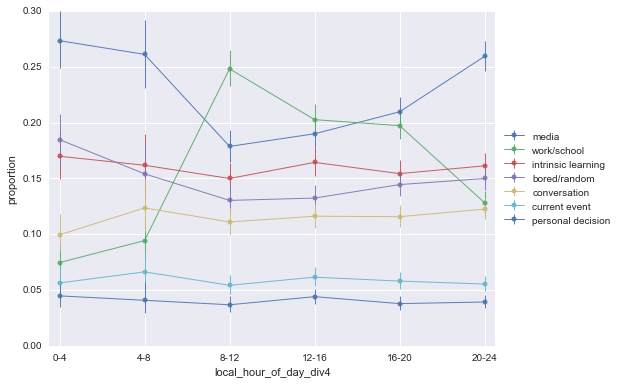

In [26]:
x = 'local_hour_of_day_div4'
hue = 'motivation'
d = d_single_motivation
d = d[d['local_day_type'] == 0]
xticks = hour_of_day_div4_xticks
figsize = (8, 6)
xlim = (-0.5, 20.5)
hue_order = ['media', 'work/school',  'intrinsic learning', 'bored/random', 'conversation', 'current event', 'personal decision']
plot_over_time(d, x, xticks, hue, hue_order, figsize, xlim )

The familiar pattern. Motivations besides media and work/school maintain a fairly constant proportion throughout the day. Work/school maintains the highest proportion during work/school hours. Media has the highest proportion outside of work/school hours.

### Information Depth: Weekday vs Weekend

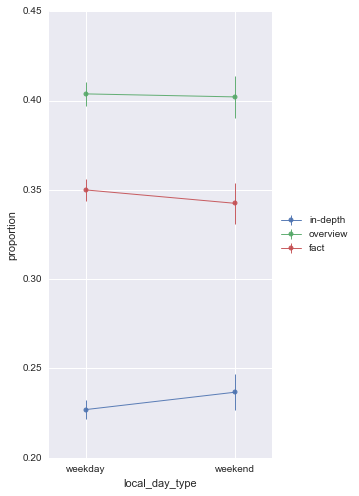

In [27]:
x = 'local_day_type'
hue = 'information depth'
xticks = day_type_xticks
figsize = (4, 8)
xlim = (-0.25, 1.25)
hue_order = ['in-depth', 'overview', 'fact']
plot_over_time(df, x, xticks, hue, hue_order, figsize, xlim )

Non of the differences are significant, athough it appears as if a higher proportion of respondents are seeking an in depth reading on the weekend.

### Information Depth: Hour of Day

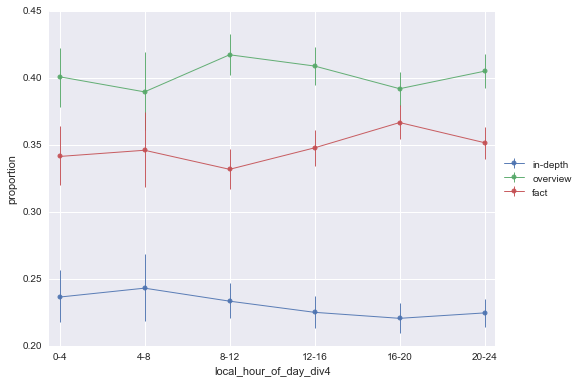

In [28]:
x = 'local_hour_of_day_div4'
hue = 'information depth'
d = df[df['local_day_type'] == 0]
xticks = hour_of_day_div4_xticks
figsize = (8, 6)
xlim = (-0.5, 20.5)
hue_order = ['in-depth', 'overview', 'fact']
plot_over_time(d, x, xticks, hue, hue_order, figsize, xlim )

Not much. Maybe a bump in overview and a dip in fact during the day.

### Information Depth: Weekday vs Weekend

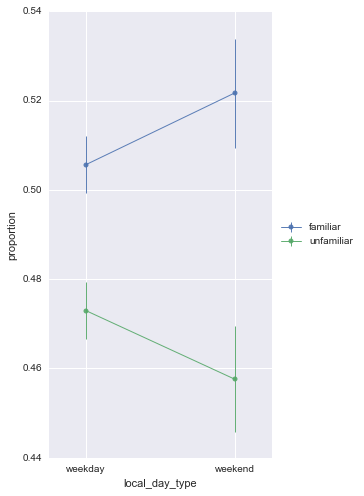

In [29]:
x = 'local_day_type'
hue = 'prior knowledge'
xticks = day_type_xticks
figsize = (4, 8)
xlim = (-0.25, 1.25)
hue_order = ['familiar', 'unfamiliar']
plot_over_time(df, x, xticks, hue, hue_order, figsize, xlim )

Again, no significant change. Weekend readrs may be more likely to familiar with the topic.

### Information Depth: Hour of Day

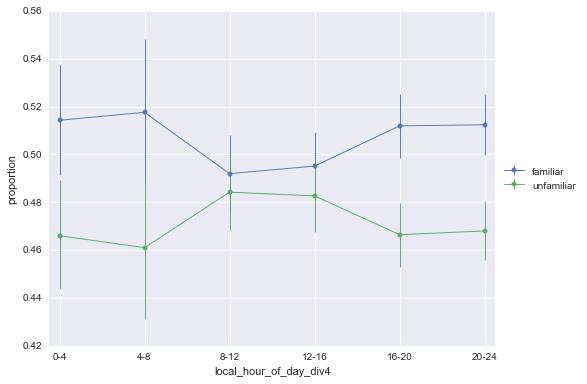

In [30]:
x = 'local_hour_of_day_div4'
hue = 'prior knowledge'
d = df[df['local_day_type'] == 0]
xticks = hour_of_day_div4_xticks
figsize = (8, 6)
xlim = (-0.5, 20.5)
hue_order = ['familiar', 'unfamiliar']
plot_over_time(d, x, xticks, hue, hue_order, figsize, xlim )

Again, not much. Maybe a bump in unfamiliar and a dip in familiar during the day.